## import libary

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.image as mping
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, Activation, Cropping2D, Dropout, Flatten
from keras.models import Sequential,Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


### import images data

In [2]:
def getImagesAngles(csv_path):
    """
    Get center, left, right images and angles from csv_data
    
    Arguments:
        csv_data: CVS data
    Returns:
        centerimages,leftimages,rightimages,angles
    """
    csv_colums = ["center","left","right","steering","throttle","brake","speed"]
    
    # Read CSV file
    with open(csv_path) as cvsfile:
        csv_data = pd.read_csv(cvsfile,names=csv_colums)
    
    # Read images and angles
    headpath = os.path.split(csv_path)[0]
    centerimages = []
    leftimages = []
    rightimages = []
    angles = []
    for c,l,r,a in zip(csv_data["center"],csv_data["left"],csv_data["right"],csv_data["steering"]):
        c_current_path = headpath + '/IMG/' + c.split('\\')[-1] # center images current path
        l_current_path = headpath + '/IMG/' + l.split('\\')[-1] # left images current path
        r_current_path = headpath + '/IMG/' + r.split('\\')[-1] # right images current path
        
        centerimage = mping.imread(c_current_path)
        leftimage = mping.imread(l_current_path)
        rightimage = mping.imread(r_current_path)
        
        centerimages.append(centerimage)
        leftimages.append(leftimage)
        rightimages.append(rightimage)
        angles.append(a)
    
    return csv_data, centerimages, leftimages, rightimages, angles

def combineImagesAngles(centerimages, leftimages, rightimages,angles, correction):
    """
    Combine "center", "left", "right" images using the correction factor "correction"
    
    Returns:
        images, measurements
    """
    images = []
    images.extend(centerimages)
    images.extend(leftimages)
    images.extend(rightimages)
    
    measurements = []
    measurements.extend(angles)
    measurements.extend(x + correction for x in angles) # left image angle move to center, angle is list can not using (angles - correction)
    measurements.extend(x - correction for x in angles) # right image angle move to center
    
    return np.array(images), np.array(measurements)

## Road 1

In [3]:
csv_data1, centerimages1, leftimages1,rightimages1,angles1 = getImagesAngles("./data_run1/driving_log.csv") 
print(np.shape(centerimages1))
print(np.shape(leftimages1))
print(np.shape(rightimages1))
print(np.shape(angles1))
csv_data1.head()

(2491, 160, 320, 3)
(2491, 160, 320, 3)
(2491, 160, 320, 3)
(2491,)


,center,left,right,steering,throttle,brake,speed
0,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,11.14113
1,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,11.07376
2,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,10.98476
3,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.241891,0,11.01884
4,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.417623,0,11.19517


In [4]:
X_train1, y_train1 = combineImagesAngles(centerimages1, leftimages1, rightimages1, angles1,0.2)
print(X_train1.shape)
print(y_train1.shape)

(7473, 160, 320, 3)
(7473,)


## Road 2 data

In [5]:
csv_data2, centerimages2, leftimages2, rightimages2, angles2 = getImagesAngles("./data_run2/driving_log.csv") 
print(np.shape(centerimages2))
print(np.shape(leftimages2))
print(np.shape(rightimages2))
print(np.shape(angles2))

(4494, 160, 320, 3)
(4494, 160, 320, 3)
(4494, 160, 320, 3)
(4494,)


In [6]:
X_train2, y_train2 = combineImagesAngles(centerimages2, leftimages2,rightimages2,angles2 ,0.2)
print(X_train2.shape)
print(y_train2.shape)

(13482, 160, 320, 3)
(13482,)


## Merge data

In [7]:
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
print(X_train.shape)
print(y_train.shape)

(20955, 160, 320, 3)
(20955,)


### Show left, center and right images

In [8]:
def showviewpoint(leftimages, centerimages, rightimages, angles):
    index = np.random.randint(len(centerimages))
    
    leftimage, centerimage, rightimage = leftimages[index], centerimages[index], rightimages[index]
    l_angle, c_angle, r_angle = angles[index] + 0.2, angles[index], angles[index] - 0.2
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,3,1)
    plt.imshow(leftimage)
    plt.title('Left Image,steering angle.{:.3f}'.format(l_angle))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,2)
    plt.imshow(centerimage)
    plt.title('Center Image,steering angle.{:.3f}'.format(c_angle))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(rightimage)
    plt.title('Right Image ,steering angle.{:.3f}'.format(r_angle))
    plt.yticks([])
    plt.xticks([])

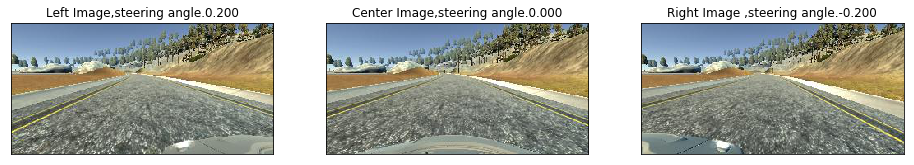

In [9]:
showviewpoint(leftimages1, centerimages1,rightimages1,angles1)

## Define Augument Function

In [10]:
import cv2
from skimage.util import random_noise

def gamma_correction(image,gamma):
    """
    image Gamma Correction
    x: source img, array like
    gamma: >1 image darken; <1 image brighten
    """
    img = image/255.0
    img = cv2.pow(img,gamma) * 255.0
    # img = img.clip(0,255) # 不会超出范围，因为1的幂还是1
    return img.astype(np.uint8)

def gamma_image(image,angle,gamma=0.8):
    """
    Radomly gamma correction gamma from 0.8-2.8
    """
    # 这里用到了HSV或者HSL的明度通道
    img_cvt = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    img_cvt[:,:,2] = gamma_correction(img_cvt[:,:,2], 2*np.random.sample(1)+gamma)
    return cv2.cvtColor(img_cvt, cv2.COLOR_HSV2RGB),angle
    
def gaussian_blur(image,angle,kernel_size=3):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0),angle    
    
def gaussian_noise(img,angle,mode='gaussian'):
    var = 0.01*np.random.random_sample(1)
    return np.uint8(255*random_noise(img/255.,mode=mode,var=var)),angle

def image_fliplr(image, angle):
    return np.fliplr(image), angle*(-1)
    
def shadow_transform(image,angle,hlimit=80,wlimit=80):
    """
    Randomly add projection on image
    
    """
    alpha = np.random.sample(1)
    img_shape = image.shape
    
    height = np.random.randint(0,hlimit)
    weight = np.random.randint(0,wlimit)
    row = np.random.randint(0,img_shape[0]-height) # 最底下进去一个高度，防止出界
    col = np.random.randint(0,img_shape[1]-weight) # 最右边减去一个宽度，防止出界
    result = np.copy(image)
    result[row:row+height,col:col+weight,0] = 128
    result[row:row+height,col:col+weight,1] = 128
    result[row:row+height,col:col+weight,2] = 128
    return result,angle

def image_shift(img,angle, shift_range = 100):
    """
    Shift image and angle horizontally
    """
    w = img.shape[0]
    h = img.shape[1]
    
    shift_x = shift_range*(np.random.uniform(low=0.0, high=1.0) - 0.5)
    shift_y = 0
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    image = cv2.warpAffine(img, M, (h,w))
    
    angle = angle + shift_x/w
    return image, angle
    

def augument_images_process(batch_images,batch_angles,gammarate=0.5,blurrate=0.5,projectionrate=0.5,shiftrate=0.4):
    images = []
    angles = []
    for img,angle in zip(batch_images,batch_angles):
        img_ = np.copy(img)
        angle_ = np.copy(angle)
        if(np.random.sample(1) < gammarate):
            img_, angle_ = gamma_image(img_,angle_)
        
        if(np.random.sample(1) < blurrate):
            img_, angle_ = gaussian_blur(img_,angle_)
        
        if(np.random.sample(1) < projectionrate):
            img_, angle_ = shadow_transform(img_,angle_)
            
        if(np.random.sample(1) < shiftrate):
            img_, angle_ = image_shift(img_,angle_)
            
        img_, angle_ = gaussian_noise(img_,angle_)
        
        images.append(img_)
        angles.append(angle_)
        
        imgflip,angleflip = image_fliplr(img, angle)
        img_ = imgflip
        angle_ = angleflip
        
        if(np.random.sample(1) < gammarate):
            img_, angle_ = gamma_image(img_,angle_)
        
        if(np.random.sample(1) < blurrate):
            img_, angle_ = gaussian_blur(img_,angle_)
        
        if(np.random.sample(1) < projectionrate):
            img_, angle_ = shadow_transform(img_,angle_)
            
        if(np.random.sample(1) < shiftrate):
            img_, angle_ = image_shift(img_,angle_)
            
        img_, angle_ = gaussian_noise(img_,angle_)
        
        images.append(img_)
        angles.append(angle_)
    return np.array(images), np.array(angles)   

#### Test gamma_image function

Text(0.5,1,'Gamma Image')

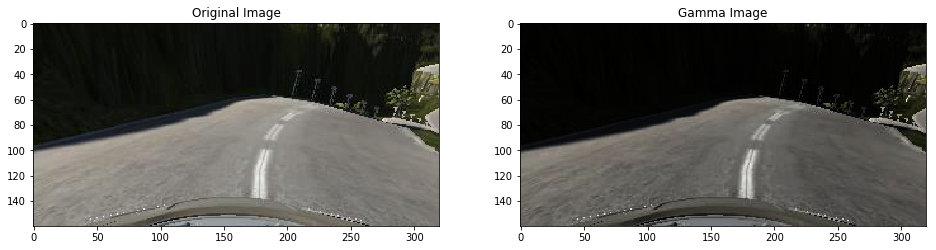

In [11]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = gamma_image(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Gamma Image')
# plt.yticks([])
# plt.xticks([])

#### Test gaussion_blur Function

Text(0.5,1,'Gaussion Blur Image')

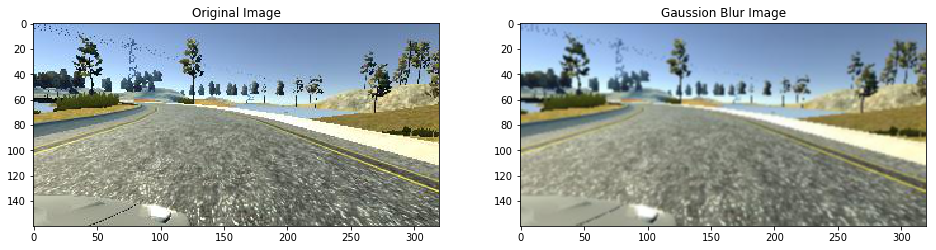

In [12]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = gaussian_blur(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Gaussion Blur Image')
# plt.yticks([])
# plt.xticks([])

#### Test gaussion_noise Function

Text(0.5,1,'Gaussion Noise Image')

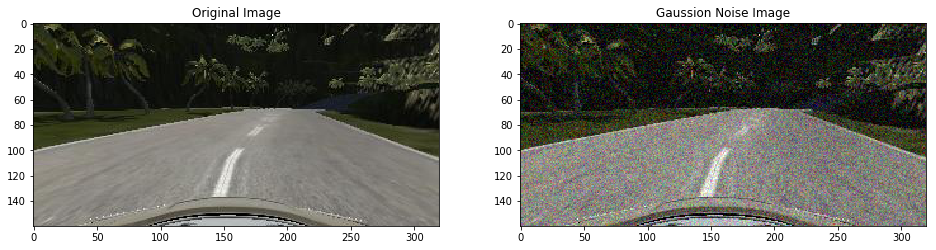

In [13]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = gaussian_noise(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Gaussion Noise Image')
# plt.yticks([])
# plt.xticks([])

#### Test image_fliplr Function

Text(0.5,1,'Flip Image')

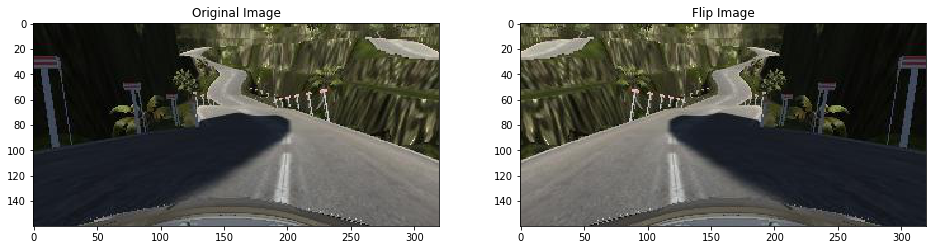

In [14]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = image_fliplr(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Flip Image')
# plt.yticks([])
# plt.xticks([])

#### Test add shadow Funcion

Text(0.5,1,'Shadow Image')

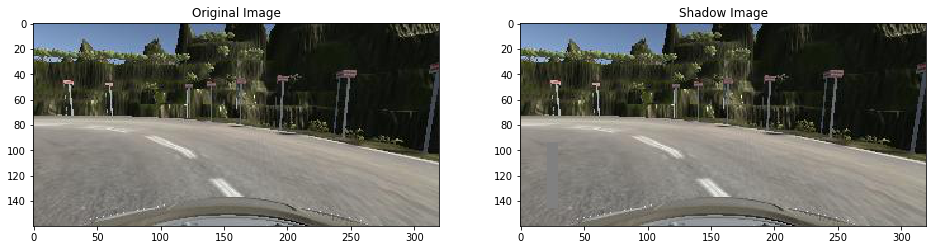

In [15]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = shadow_transform(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Shadow Image')
# plt.yticks([])
# plt.xticks([])

####  Test image_shift Function

Text(0.5,1,'Shift Image')

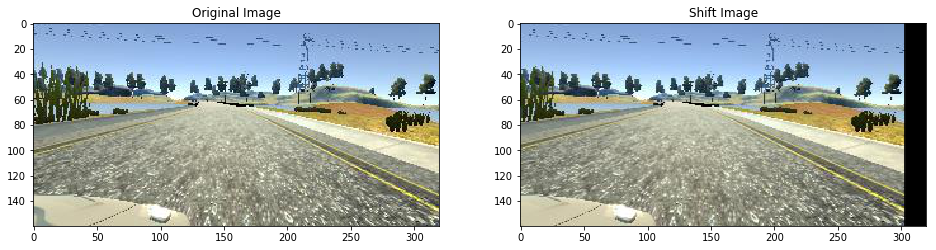

In [16]:
index1 = np.random.randint(len(X_train))
test_X = X_train[index1]
test_y = y_train[index1]
X,_ = image_shift(test_X, test_y)
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(test_X)
plt.title('Original Image')
# plt.yticks([])
# plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(X)
plt.title('Shift Image')
# plt.yticks([])
# plt.xticks([])

#### Test augument_images_process Funcion

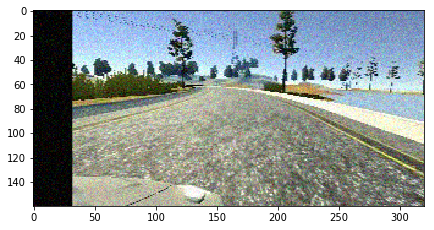

In [17]:
index1 = np.random.randint(len(X_train))
X,y = augument_images_process(X_train[index1:index1+10],y_train[index1:index1+10])
plt.figure(figsize=(7,7))
plt.imshow(X[np.random.randint(10)])

## Define cropping Function

In [18]:
def crop_img(img,top_crop=70, bottom_crop=25,left_crop=0, right_crop=0):
    """
    Crop Image
    
    Arguments:
        img: array like data
        top_crop: how much top rows should be cropped
        bottom_crop: how much bottom rows should be cropped
        left_crop: how much left cols should be cropped
        right_crop: how much cols right should be cropped
    """
    row = img.shape[0]
    col = img.shape[1]

    print(img.shape)
    plt.figure(figsize=(16, 8))
    plt.subplot(2,2,1)
    plt.imshow(img)
    plt.title('Original Image')
#     plt.yticks([])
#     plt.xticks([])

    plt.subplot(2,2,2)
    plt.imshow(img[row-top_crop:row-bottom_crop, left_crop:col-right_crop])
    plt.title('Focused Image')
#     plt.yticks([])
#     plt.xticks([])
    
    plt.subplot(2,2,3)
    plt.imshow(img[:top_crop,left_crop:col-right_crop])
    plt.title('Top Cropped Image')
#     plt.yticks([])
#     plt.xticks([])

    plt.subplot(2,2,4)
    plt.imshow(img[row-bottom_crop:, left_crop:col-right_crop])
    plt.title('Bottom Cropped Image')
#     plt.yticks([])
#     plt.xticks([])

(160, 320, 3)


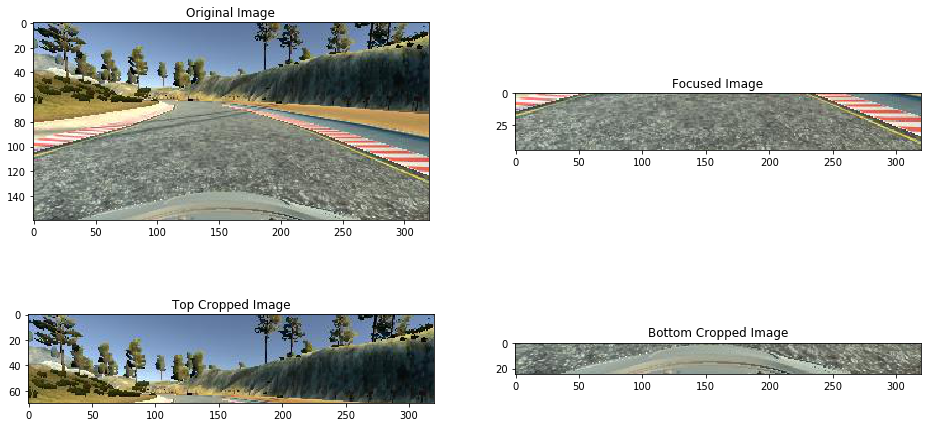

In [19]:
crop_img(X_train[np.random.randint(1)])

### Define Generator Function

In [20]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
# The number of samples in the batch
NUM_BATCH_SAMPLES = 64

# The number of samples in the train set
NUM_TRAIN_SAMPLES = len(X_train)
# Train steps per epoch
NUM_TRAIN_STEPS = math.ceil(NUM_TRAIN_SAMPLES/NUM_BATCH_SAMPLES)

# The number of samples in the valid set
NUM_VALID_SAMPLES = len(X_valid)
# Valid steps per epoch
NUM_VALID_STEPS = math.ceil(NUM_VALID_SAMPLES/NUM_BATCH_SAMPLES)

In [22]:
def generator(images, angles, batch_size = NUM_BATCH_SAMPLES):
    """
    Generate the required images and angles for taining, the return batch size is double batch_size
    """
    num_samples = len(images)
    while 1: 
        for offset in range(0,num_samples,batch_size):
            batch_images = images[offset:offset + batch_size]
            batch_angles = angles[offset:offset + batch_size]
            
            inputs,outputs = augument_images_process(batch_images,batch_angles)
            
            yield inputs,outputs

In [23]:
train_generator = generator(X_train,y_train)
valid_generator = generator(X_valid,y_valid)

## Model Architecture

In [24]:
x = Input(shape=(160,320,3))
y = Lambda(lambda x: x/250.0 - 0.5)(x)
y = Cropping2D(cropping=((70,25),(0,0)))(y)
y = Conv2D(24,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.5)(y)
y = Flatten()(y)
y = Dense(100,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(50,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(10,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.1)(y)
y = Dense(1)(y)
model = Model(inputs=x, outputs=y)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
__________

In [25]:
def trainModel(model=model,train_generator=train_generator,valid_generator=valid_generator,batch_size=128, epochs=50, lr=0.0005, patience=10, verbose=1, savefile='./model.h5'):
    adam_optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=adam_optimizer,loss=keras.losses.mean_squared_error)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience)
    
    train_history = model.fit_generator(train_generator,steps_per_epoch=NUM_TRAIN_STEPS ,validation_data=valid_generator,validation_steps=NUM_VALID_STEPS,epochs=epochs, verbose=verbose, callbacks=[earlystop],shuffle=True)
    
    model.save(savefile)
    
    # plot the training and validation loss for each epoch
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='best')
    plt.show()

Epoch 1/50
262/262 [==============================] - 618s 2s/step - loss: 0.2560 - val_loss: 0.1852
Epoch 2/50
262/262 [==============================] - 589s 2s/step - loss: 0.1687 - val_loss: 0.1445
Epoch 3/50
262/262 [==============================] - 565s 2s/step - loss: 0.1372 - val_loss: 0.1270
Epoch 4/50
262/262 [==============================] - 545s 2s/step - loss: 0.1210 - val_loss: 0.1182
Epoch 5/50
262/262 [==============================] - 582s 2s/step - loss: 0.1101 - val_loss: 0.1089
Epoch 6/50
262/262 [==============================] - 561s 2s/step - loss: 0.1043 - val_loss: 0.1042
Epoch 7/50
262/262 [==============================] - 557s 2s/step - loss: 0.0999 - val_loss: 0.0963
Epoch 8/50
262/262 [==============================] - 569s 2s/step - loss: 0.0994 - val_loss: 0.1010
Epoch 9/50
262/262 [==============================] - 554s 2s/step - loss: 0.0961 - val_loss: 0.0983
Epoch 10/50
262/262 [==============================] - 552s 2s/step - loss: 0.0933 - val_lo

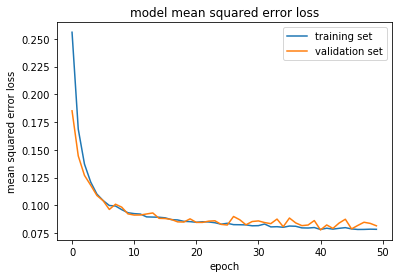

In [26]:
trainModel(model,train_generator,valid_generator,verbose=1)

In [28]:
from keras.models import load_model

def finetuneModel( train_generator,valid_generator, epochs, lr=0.0001, verbose=1, loadfile='./model.h5'):
    model = load_model(loadfile)
    trainModel(model,train_generator,valid_generator,epochs=epochs,lr=lr,verbose=verbose, savefile=loadfile)

Epoch 1/10
262/262 [==============================] - 616s 2s/step - loss: 0.0724 - val_loss: 0.0721
Epoch 2/10
262/262 [==============================] - 562s 2s/step - loss: 0.0708 - val_loss: 0.0729
Epoch 3/10
262/262 [==============================] - 587s 2s/step - loss: 0.0707 - val_loss: 0.0717
Epoch 4/10
262/262 [==============================] - 570s 2s/step - loss: 0.0698 - val_loss: 0.0724
Epoch 5/10
262/262 [==============================] - 570s 2s/step - loss: 0.0695 - val_loss: 0.0716
Epoch 6/10
262/262 [==============================] - 575s 2s/step - loss: 0.0689 - val_loss: 0.0701
Epoch 7/10
262/262 [==============================] - 605s 2s/step - loss: 0.0683 - val_loss: 0.0690
Epoch 8/10
262/262 [==============================] - 589s 2s/step - loss: 0.0686 - val_loss: 0.0697
Epoch 9/10
262/262 [==============================] - 584s 2s/step - loss: 0.0687 - val_loss: 0.0704
Epoch 10/10
262/262 [==============================] - 598s 2s/step - loss: 0.0680 - val_lo

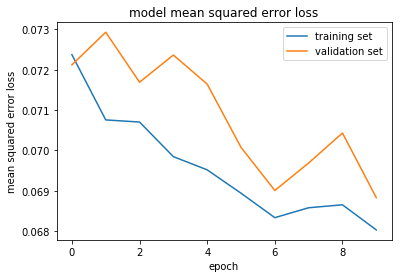

In [29]:
finetuneModel(train_generator,valid_generator,epochs=10, lr=0.0001,verbose=1)